In [1]:
from tqdm.notebook import tqdm
import pandas as pd
import os
import re
from pandarallel import pandarallel
import reverse_geocode


pandarallel.initialize(progress_bar=True)
tqdm.pandas()

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
datasets = {}

for file in os.listdir("../data/all_cities"):
    pattern = r'_(\w{2})'
    match = re.search(pattern, file)
    result = match.group(1)
    datasets[f"df_{result}"] = pd.read_csv(f"../data/all_cities/{file}")
df = pd.concat([value for key, value in datasets.items()], ignore_index=True)

df.shape

(96015, 75)

# Retrieving location from coordinates


In [3]:
def retrieve_city(row):
    coords = (row["latitude"], row['longitude'])
    row["listing_city"] = reverse_geocode.get(coords)["city"]
    row["listing_city_pop"] = reverse_geocode.get(coords)["population"]
    return row

df = df.parallel_apply(retrieve_city, axis=1)

In [4]:
sep_nas = pd.DataFrame(df.isnull().sum(), columns=["NAs"])
sep_nas.loc[sep_nas["NAs"] > 0, :]

,NAs
description,2861
neighborhood_overview,41432
host_name,1
host_since,1
host_location,22088
host_about,48562
host_response_time,11774
host_response_rate,11774
host_acceptance_rate,7630
host_is_superhost,2182


## Drop columns with too many NAs

In [5]:
df.drop(["neighborhood_overview",
             "host_about",
             "host_neighbourhood",
             "neighbourhood",
             "neighbourhood_group_cleansed",
             "calendar_updated",
             "license"],
            axis=1,
            inplace=True)

## Drop not useful

In [6]:
df.drop([
    "listing_url",
    "scrape_id",
    "last_scraped",
    "source",
    "name",
    "description",
    "picture_url",
    "host_url",
    "host_name",
    "host_thumbnail_url",
    "host_picture_url",
    "minimum_minimum_nights",
    "maximum_minimum_nights",
    "minimum_maximum_nights",
    "maximum_maximum_nights",
    "minimum_nights_avg_ntm",
    "maximum_nights_avg_ntm",
    "has_availability",
    "availability_30",
    "availability_60",
    "availability_90",
    "availability_365",
    "calendar_last_scraped",
    "number_of_reviews_ltm",
    "number_of_reviews_l30d",
    "instant_bookable",
    "calculated_host_listings_count",
    "calculated_host_listings_count_entire_homes",
    "calculated_host_listings_count_private_rooms",
    "calculated_host_listings_count_shared_rooms",
],
axis=1,
inplace=True)

df.set_index("id", inplace=True)

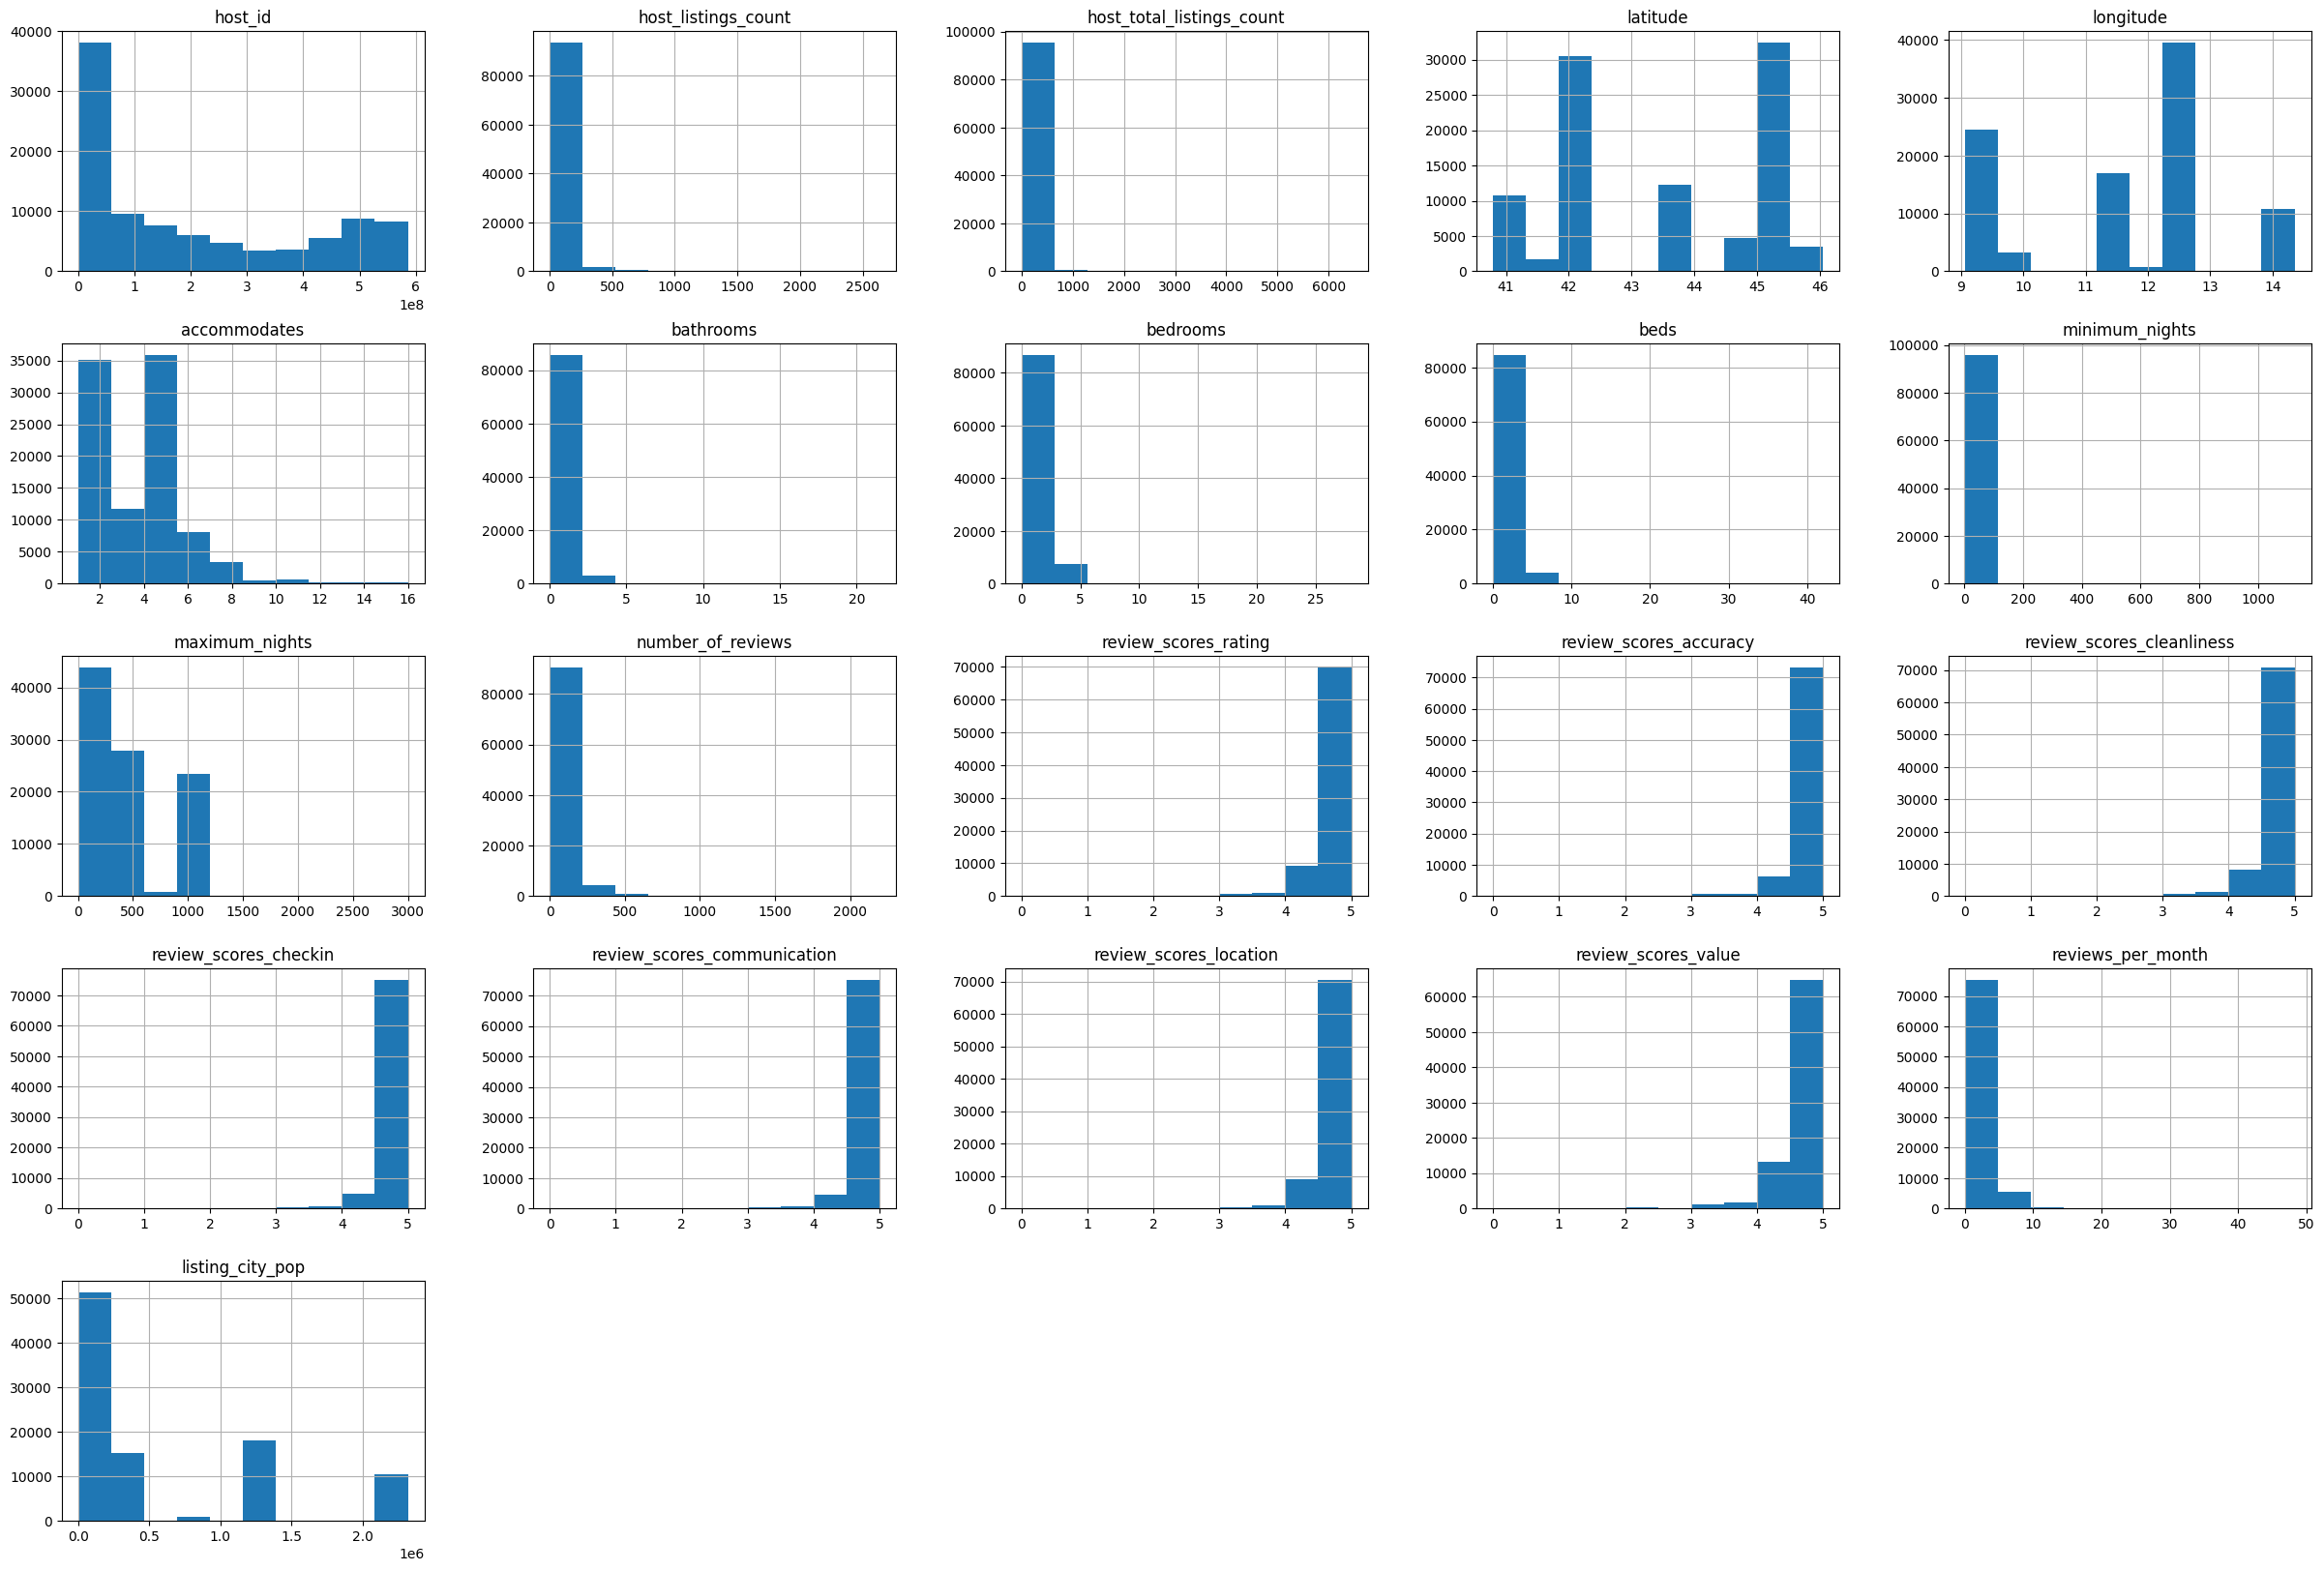

In [7]:
see_histograms = df.copy()

pd.set_option('future.no_silent_downcasting', True)
see_histograms.replace({'f': 0, 't': 1}, inplace=True)

see_histograms.hist(figsize=(30,20));

In [8]:
print(df.shape)
df_nas_columns = pd.DataFrame({
    'NAs': df.isnull().sum(axis=1),
    'Columns_with_NAs': df.parallel_apply(lambda x: ', '.join(x.index[x.isnull()]), axis=1)
})
df_nas_columns.loc[df_nas_columns["NAs"]>7]

(96015, 39)


,NAs,Columns_with_NAs
id,,
482422,13,"host_location, host_response_time, host_respon..."
523048,10,"first_review, last_review, review_scores_ratin..."
523221,13,"bathrooms, beds, price, first_review, last_rev..."
531903,10,"first_review, last_review, review_scores_ratin..."
1190641,13,"host_response_time, host_response_rate, host_a..."
...,...,...
1178237255401102369,10,"first_review, last_review, review_scores_ratin..."
1178241933628166985,13,"host_response_time, host_response_rate, host_a..."
1178285228892794868,10,"first_review, last_review, review_scores_ratin..."


In [9]:
more_than_7_missing = df_nas_columns.loc[df_nas_columns["NAs"]>7, :].index.tolist()
df.drop(more_than_7_missing, inplace=True)
df.shape

(81316, 39)

# Handling amenities

In [10]:
amenities_lists = df["amenities"].tolist()

amenities_counter = {}

for el in amenities_lists:
    for e in el.strip('][').split(', '):
        try:
            amenities_counter[e.strip('"')] += 1
        except:
            amenities_counter[e.strip('"')] = 1

amenities_counter = dict(sorted(amenities_counter.items(), key=lambda item: item[1], reverse=True))


## Remapping amenities in smaller dictionary

In [11]:
amenities_remapping = {}


### technology

In [12]:
pattern = r'\b(wifi|internet|ethernet|cable|fibra|dolby|smart|connection|tv|television|netflix|amazon|disney)\b'
regex = re.compile(pattern, re.IGNORECASE)

for am in list(amenities_counter.keys()):
    if regex.search(am):
        amenities_remapping[am] = "technology"

### kitchen

In [13]:
pattern = r'\b(kitchen|cooking|grill|cucina|refrigerator|fridge|oven|stove|dish|coffee|espresso|lavazza|dining|breakfast|microonde|microwave|washer|freezer|glasses|toast|baking)\b'
regex = re.compile(pattern, re.IGNORECASE)

for am in list(amenities_counter.keys()):
    if regex.search(am):
        amenities_remapping[am] = "kitchen"

### toiletry

In [14]:
pattern = r'\b(hair|capelli|soap|sapone|bidet|shampoo|bathtub|gel|laundry|closet|pillow|blanket|shower)\b'
regex = re.compile(pattern, re.IGNORECASE)

for am in list(amenities_counter.keys()):
    if regex.search(am):
        amenities_remapping[am] = "toiletry"

### AC/heating

In [15]:
pattern = r'\b(heating|ac|air|conditioning|fan)\b'
regex = re.compile(pattern, re.IGNORECASE)

for am in list(amenities_counter.keys()):
    if regex.search(am):
        amenities_remapping[am] = "AC/heating"

### benefits

In [16]:
pattern = r'\b(garden|backyard|skyline|beach|gym|fitness|view|outdoor|balcony|waterfront|bed linen|workspace|aid|luggage|elevator|free|safe|lock|security|bike|estinguisher)\b'
regex = re.compile(pattern, re.IGNORECASE)

for am in list(amenities_counter.keys()):
    if regex.search(am):
        amenities_remapping[am] = "benefits"

### other

In [17]:
pattern = r'\b(wifi|internet|ethernet|cable|fibra|dolby|smart|connection|tv|television|netflix|amazon|disney|kitchen|cooking|grill|cucina|refrigerator#|fridge|oven|stove|dish|coffee|espresso|lavazza|dining|breakfast|microonde|microwave|washer|freezer|glasses|toast|baking|hair|capelli|soap|sapone|bidet#|shampoo|bathtub|gel|laundry|closet|pillow|blanket|showers|heating|ac|air|conditioning|fan|garden|backyard|skyline|beach|gym|fitness|view|outdoor#|balcony|waterfront|bed linen|workspace|aid|luggage|elevator|free|safe|lock|security|bike)\b'

regex = re.compile(pattern, re.IGNORECASE)

for am in list(amenities_counter.keys()):
    if not regex.search(am):
        amenities_remapping[am] = "other"

## Remapping amenities in dataframe

In [18]:
def unwrap_remap_amenities(value):
    element = [e.strip('"') for e in value.strip('][').split(', ')]
    remapped_amenities = (pd.Series(element)).map(amenities_remapping)
    return remapped_amenities.tolist()

df["amenities"] = df["amenities"].parallel_apply(unwrap_remap_amenities)

In [19]:
def return_amenity_counter(row):
    amenities = ["AC/heating", "technology", "kitchen", "benefits", "toiletry", "other"]
    counts = {amenity: row["amenities"].count(amenity) for amenity in amenities}
    for amenity, count in counts.items():
        row[f'amenities_{amenity}'] = count
    return row

df = df.parallel_apply(return_amenity_counter, axis=1)


In [20]:
df.loc[df["host_location"]=="Venice, Italy"]

,host_id,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,...,review_scores_value,reviews_per_month,listing_city,listing_city_pop,amenities_AC/heating,amenities_technology,amenities_kitchen,amenities_benefits,amenities_toiletry,amenities_other
id,,,,,,,,,,,,,,,,,,,,,
24329287,10258694,2013-11-25,"Venice, Italy",within a few hours,100%,100%,f,1.0,1.0,"['email', 'phone', 'work_email']",...,4.75,0.28,Florence,367150,2,3,6,1,2,12
1168604518137636191,41699367,2015-08-17,"Venice, Italy",within an hour,100%,100%,f,63.0,81.0,"['email', 'phone']",...,5.00,2.00,Florence,367150,2,2,7,5,5,22
6623,15016,2009-04-27,"Venice, Italy",within a day,88%,78%,t,8.0,16.0,"['email', 'phone']",...,4.92,1.04,Venice,51298,2,2,11,3,4,24
27116,116144,2010-04-30,"Venice, Italy",within a few hours,67%,100%,f,3.0,3.0,"['email', 'phone']",...,4.78,2.46,Venice,51298,2,2,5,2,1,9
44527,120215,2010-05-07,"Venice, Italy",within an hour,100%,100%,t,3.0,7.0,"['email', 'phone', 'work_email']",...,4.68,0.86,Venice,51298,2,2,11,3,6,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1121571978292906275,12174833,2014-02-12,"Venice, Italy",a few days or more,40%,25%,f,1.0,1.0,"['email', 'phone']",...,5.00,1.25,Rome,2318895,1,1,2,2,1,5
1140385901206525073,41699367,2015-08-17,"Venice, Italy",within an hour,100%,100%,f,51.0,73.0,"['email', 'phone']",...,4.00,1.00,Rome,2318895,1,2,10,5,5,20
1141043859299230155,41699367,2015-08-17,"Venice, Italy",within an hour,100%,100%,f,51.0,73.0,"['email', 'phone']",...,3.00,2.00,Rome,2318895,2,1,10,8,5,18


In [51]:
sep_nas = pd.DataFrame(df.isnull().sum(), columns=["NAs"])
sep_nas.loc[sep_nas["NAs"] > 0, :]

,NAs
host_response_time,7373
host_response_rate,7373
host_acceptance_rate,3743
host_is_superhost,1938
bathrooms,4754
bathrooms_text,74
bedrooms,866
beds,4896
price,4735
review_scores_accuracy,58


## Fill Host Locations NAs with the values from the same HostID or same listing city

In [49]:
def fill_host_location(row):
    if pd.isna(row["host_location"]):
        row["host_location"] = row["listing_city"]+", Italy"
    return row

df = df.parallel_apply(fill_host_location, axis=1)